In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

In [ ]:
# default_exp combichem

# Combichem

> Combinatorial chemistry functions

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export

from mrl.imports import *
from mrl.core import *
from mrl.chem import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
# export

class Crossover():
    def __call__(self, mols):
        mols = to_mols(mols)
        shuffle_idxs = np.random.choice(range(len(mols)), len(mols), replace=False)
        pairs = [(mols[i], mols[shuffle_idxs[i]]) for i in range(len(mols))]
        outputs = maybe_parallel(self.crossover, pairs)
        return flatten_list_of_lists(outputs)
    
    def crossover(self, mol_pair):
        raise NotImplementedError

In [ ]:
# export

class FragmentCrossover(Crossover):
    def __init__(self, full_crossover=False):
        self.full_crossover = full_crossover
        
    def crossover(self, mol_pair):
        mol1, mol2 = mol_pair
        cores1, rgroups1 = self.split_fragments(self.fragment(to_mol(mol1)))
        cores2, rgroups2 = self.split_fragments(self.fragment(to_mol(mol2)))
        
        outputs = self.merge_groups(cores1, rgroups2)
        outputs += self.merge_groups(cores2, rgroups1)
        return outputs
        
    def merge_groups(self, cores, rgroups):
        random.shuffle(cores)
        random.shuffle(rgroups)
        if self.full_crossover:
            inputs = list(itertools.product(cores, rgroups))
            inputs = ['.'.join(i) for i in inputs]
        else:
            inputs = [cores[i]+'.'+rgroups[i] for i in range(min(len(cores), len(rgroups)))]
        fused = [fuse_on_atom_mapping(i) for i in inputs]
        return fused
        
    def fragment(self, mol):
        fragments = [i[1] for i in fragment_mol(mol, 1)]
        return fragments
    
    def split_fragments(self, fragments):
        cores = []
        rgroups = []
        
        for fragment in fragments:
            core, rgroup = self.split_fragment(fragment)
            cores.append(core)
            rgroups.append(rgroup)
            
        return cores, rgroups
    
    def split_fragment(self, fragment):
        f1, f2 = fragment.split('.')
        if len(f1)>len(f2):
            core = f1
            rgroup = f2
        else:
            core = f2
            rgroup = f1
            
        return core, rgroup

In [ ]:
df = pd.read_csv('files/smiles.csv')
mols = to_mols(df.smiles.values[:10])
cx = FragmentCrossover()
out = cx(mols)

In [ ]:
# export

class Mutator():
    def __init__(self, name=None):
        if name is None:
            name='Mutator'
        self.name = name
    def __call__(self, mols):
        if is_container(mols):
            mols = to_mols(mols)
            outputs = maybe_parallel(self.mutate, mols)
            outputs = flatten_list_of_lists(outputs)
        else:
            mols = to_mol(mols)
            outputs = self.mutate(mols)
        
        return outputs
    
    def mutate(self, mol):
        raise NotImplementedError
        
    def __repr__(self):
        return self.name

In [ ]:
# export

class SmartsMutator(Mutator):
    def __init__(self, smarts, name=None):
        if name is None:
            name = 'Smarts Mutator'
        self.name = name
        
        self.smarts = smarts
        self.rxns = [smart_to_rxn(i) for i in self.smarts]
        for r in self.rxns:
            r.Initialize()
            
    def __add__(self, other, name=None):
        smarts = self.smarts + other.smarts
        if name is None:
            name = self.name + ' + ' + other.name
        
        return SmartsMutator(smarts, name=name)
    
    def mutate(self, mol):
        
        rxn_idxs = np.random.choice(range(len(self.rxns)), len(self.rxns), replace=False)
        products = []
        
        for idx in rxn_idxs:
            if self.rxns[idx].IsMoleculeReactant(mol):
                selected_rxn = self.rxns[idx]
                try:
                    products = [to_smile(i[0]) for i in selected_rxn.RunReactants([mol])]
                except:
                    pass
            if products:
                break

        return products

    def __repr__(self):
        r = f'{self.name}: {len(self.smarts)} Reactions'
        return r

In [ ]:
# export

class ChangeAtom(SmartsMutator):
    def __init__(self):
        atom_types = ['6', '7', '8', '9', '15', '16', '17', '35']
        
        smarts = []
        for a1 in atom_types:
            for a2 in atom_types:
                if not a1==a2:
                    smart = f'[#{a1}:1]>>[#{a2}:1]'
                    smarts.append(smart)
        
        super().__init__(smarts, name='Change Atom')
        
class AppendAtomSingle(SmartsMutator):
    def __init__(self):
        atom_types = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
        smarts = []
        for a in atom_types:
            smart = f'[*;!H0:1]>>[*:1]-{a}'
            smarts.append(smart)
        
        super().__init__(smarts, name='Append Atom Single Bond')
        
class AppendAtomsDouble(SmartsMutator):
    def __init__(self):
        atom_types = ['C', 'N', 'O', 'P', 'S']
        smarts = []
        for a in atom_types:
            smart = f'[*;!H0;!H1:1]>>[*:1]={a}'
            smarts.append(smart)
        
        super().__init__(smarts, name='Append Atom Double Bond')
        
class AppendAtomsTriple(SmartsMutator):
    def __init__(self):
        atom_types = ['C', 'N']
        smarts = []
        for a in atom_types:
            smart = f'[*;H3:1]>>[*:1]#{a}'
            smarts.append(smart)
        
        super().__init__(smarts, name='Append Atom Triple Bond')
        
class AppendAtom(SmartsMutator):
    def __init__(self):
        smarts = AppendAtomSingle().smarts 
        smarts += AppendAtomsDouble().smarts
        smarts += AppendAtomsTriple().smarts
        super().__init__(smarts, name='Append Atom')
        
class DeleteAtom(SmartsMutator):
    def __init__(self):
        smarts = [
            '[*:1]~[D1]>>[*:1]',
            '[*:1]~[D2]~[*:2]>>[*:1]-[*:2]',
            '[*:1]~[D3](~[*;!H0:2])~[*:3]>>[*:1]-[*:2]-[*:3]',
            '[*:1]~[D4](~[*;!H0:2])(~[*;!H0:3])~[*:4]>>[*:1]-[*:2]-[*:3]-[*:4]',
            '[*:1]~[D4](~[*;!H0;!H1:2])(~[*:3])~[*:4]>>[*:1]-[*:2](-[*:3])-[*:4]'
        ]
        super().__init__(smarts, name='Delete Atom')
        
class ChangeBond(SmartsMutator):
    def __init__(self):
        smarts = [
            '[*:1]@[*:2]>>([*:1].[*:2])',
            '[*:1]!-[*:2]>>[*:1]-[*:2]',
            '[*;!H0:1]-[*;!H0:2]>>[*:1]=[*:2]',
            '[*:1]#[*:2]>>[*:1]=[*:2]',
            '[*;!R;!H1;!H0:1]~[*:2]>>[*:1]#[*:2]',
        ]
        super().__init__(smarts, name='Change Bond')
        
class InsertAtomSingle(SmartsMutator):
    def __init__(self):
        atom_types = ['C', 'N', 'O', 'P', 'S']
        smarts = []
        for a in atom_types:
            smart = f'[*:1]~[*:2]>>[*:1]{a}[*:2]'
            smarts.append(smart)
        
        super().__init__(smarts, name='Insert Atom Single')
        
class InsertAtomDouble(SmartsMutator):
    def __init__(self):
        atom_types = ['C', 'N', 'P', 'S']
        smarts = []
        for a in atom_types:
            smart = f'[*;!H0:1]~[*:2]>>[*:1]={a}-[*:2]'
            smarts.append(smart)
        
        super().__init__(smarts, name='Insert Atom Double')
        
class InsertAtomTriple(SmartsMutator):
    def __init__(self):
        smarts = ['[*;!R;!H1;!H0:1]~[*:2]>>[*:1]#C-[*:2]']
        super().__init__(smarts, name='Insert Atom Triple')
        
class InsertAtom(SmartsMutator):
    def __init__(self):
        smarts = InsertAtomSingle().smarts 
        smarts += InsertAtomDouble().smarts
        smarts += InsertAtomTriple().smarts
        super().__init__(smarts, name='Insert Atom')
        
class AddRing(SmartsMutator):
    def __init__(self):
        smarts = [
        '[*;!r;!H0:1]~[*;!r:2]~[*;!r;!H0:3]>>[*:1]1~[*:2]~[*:3]1',
        '[*;!r;!H0:1]~[*!r:2]~[*!r:3]~[*;!r;!H0:4]>>[*:1]1~[*:2]~[*:3]~[*:4]1',
        '[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*;!r;!H0:5]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]1',
        '[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*!r:5]~[*;!r;!H0:6]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]~[*:6]1',
        ]
        super().__init__(smarts, name='Change Bond')
        
class AllSmarts(SmartsMutator):
    def __init__(self):
        smarts = ChangeAtom().smarts
        smarts += AppendAtom().smarts
        smarts += DeleteAtom().smarts
        smarts += ChangeBond().smarts
        smarts += InsertAtom().smarts
        smarts += AddRing().smarts
        
        super().__init__(smarts, name='Smarts Mutator')
        

In [ ]:
# export

class MutatorCollection():
    def __init__(self, mutators, p_mutators=None):
        self.mutators = mutators
        if p_mutators is None:
            p_mutators = [1/len(mutators) for i in mutators]
            
        self.p_mutators = p_mutators
        
    def __call__(self, mols):
        mutated = flatten_list_of_lists(maybe_parallel(self.mutate, mols))
        return mutated
        
    def mutate(self, mol):
        if self.mutators is not None:
            m = np.random.choice(self.mutators, 1, p=self.p_mutators)[0]
            outputs = m(mol)
        else:
            outputs = []
            
        return outputs

In [ ]:
# export

class CombiChem():
    def __init__(self, 
                 mutator_collection=None, 
                 crossovers=None,
                 template=None,
                 rewards=None,
                 prune_percentile=90,
                 max_library_size=None,
                 log=False
                ):
        
        self.mutator_collection = mutator_collection
        
        self.crossovers = crossovers
        
        self.template = template
        
        self.rewards = rewards
        
        self.prune_percentile = prune_percentile
        self.max_library_size = max_library_size
        
        self.library = pd.DataFrame([], columns=['smiles', 'mols', 'score'])
        self.old_library = pd.DataFrame([], columns=['smiles', 'score'])
        self.log = log
        
    def step(self):
        new_library = self.build_generation()
        new_library = self.clean_library(new_library)
        self.append_data(new_library)
        self.score_library()
        self.prune_library()
        
    def build_generation(self):
        mols = self.library.mols.values
        mutated = self.mutate(mols)        
        crossovers = self.crossover(mols)
        new_library = list(set(mutated+crossovers))
        return new_library
    
    def clean_library(self, library):
        if self.template is not None:
            library, _ = template.screen_mols(library)
            library = [i[0] for i in library]
        library = maybe_parallel(canon_smile, library)
        library = list(set(library))
        return library
        
    def mutate(self, mols):
        if self.mutator_collection is not None:
            outputs = self.mutator_collection(mols)
        else:
            outputs = []
            
        return outputs
    
    def crossover(self, mols):
        outputs = []
        if self.crossovers is not None:
            for cx in self.crossovers:
                outputs += cx(mols)
        return outputs
    
    def score_library(self):
        to_score = self.library[cbc.library.score.isna()]
        rewards = np.zeros(to_score.shape[0])
        
        if self.rewards is not None:
            rewards = np.zeros(to_score.shape[0])
            for reward in self.rewards:
                r_iter = reward(to_score.smiles.values)
                if isinstance(r_iter, torch.Tensor):
                    r_iter = r_iter.detach().cpu()
                rewards = rewards + np.array(r_iter)
                
        if self.template is not None:
            rewards += np.array(self.template(to_score.smiles.values, 'soft'))
                
        self.library.loc[to_score.index, 'score'] = rewards
        
        self.library['score'] = self.library.score.map(lambda x: float(x))
            
    def prune_library(self):
        cutoff = np.percentile(self.library.score.values, self.prune_percentile)
        
        n_cutoff = self.library[self.library.score >= cutoff].shape[0]
        
        if self.max_library_size is not None:
            n_cutoff = min(n_cutoff, self.max_library_size)
        
        idxs = self.library.score.nlargest(n_cutoff).index
        
        new_library = self.library.iloc[idxs]
        
        if self.log:
            old_library = self.library[~self.library.index.isin(new_library.index)]
            self.old_library = pd.concat([self.old_library, 
                                          old_library[['smiles', 'score']]])
            self.old_library.drop_duplicates(subset='smiles', inplace=True)
            self.old_library.reset_index(inplace=True, drop=True)
            
        self.library = new_library

        self.library.reset_index(inplace=True, drop=True)
        gc.collect()
        
    def add_data(self, smiles):
        smiles = to_smiles(smiles)
        smiles = self.clean_library(smiles)
        self.append_data(smiles)
        
    def append_data(self, smiles):
        mols = to_mols(smiles)
        bad_idxs = set([i for i in range(len(mols)) if mols[i] is None])
        smiles = [smiles[i] for i in range(len(smiles)) if not i in bad_idxs]
        mols = [mols[i] for i in range(len(mols)) if not i in bad_idxs]
        
        df = pd.DataFrame([[smiles[i], mols[i], None] for i in range(len(smiles))], 
                          columns=['smiles', 'mols', 'score'])
        df = df[~df.smiles.isin(self.library.smiles)]
        self.library = pd.concat([self.library, df])
        self.library.reset_index(inplace=True, drop=True)
        self.score_library()

In [ ]:
from mrl.templates.all import *

In [ ]:
from mrl.train.all import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.model_zoo import *

In [ ]:
reward_model = MLP(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2], outrange=[0,15])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_state_dict(model_from_url('egfr_affinity_mlp.pt'))

r_agent.model.eval();

freeze(r_agent.model)

reward = Reward(r_agent.predict_data, weight=1.)

aff_reward = RewardCallback(reward, 'affinity')

In [ ]:
smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]',
        '[#6]#[#6]',
        '[#15]',
        '[*]=[#17,#9,#35]',
        '[*]=[*]=[*]',
        '[*]-[#6]=[#6H2]',
        '[#7]~[#8]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-1., log=False, use_lookup=False)

In [ ]:
mutators = [
    ChangeAtom(),
    AppendAtom(),
    DeleteAtom(),
    ChangeBond(),
    InsertAtom(),
    AddRing()
]

mc = MutatorCollection(mutators)

crossovers = [FragmentCrossover()]

In [ ]:
cbc = CombiChem(mc, crossovers, template=template, rewards=[reward],
                prune_percentile=70, max_library_size=500, log=True)

In [ ]:
set_global_pool(48)

In [ ]:
agent = LSTM_LM_Small_Chembl_NC(drop_scale=0.3)

In [ ]:
def step(cbc, agent):
    new_library = cbc.build_generation()
    new_library = cbc.clean_library(new_library)
    cbc.append_data(new_library)
    preds, _ = agent.model.sample_no_grad(2048, 90)
    smiles = agent.reconstruct(preds)
    cbc.append_data(smiles)
    cbc.score_library()
    cbc.prune_library()

In [ ]:
def train_from_cbc(cbc, agent, ds_size):
    df = pd.concat([cbc.library, cbc.old_library])
    subset = df.iloc[df.score.nlargest(ds_size).index]
    agent.update_dataset_from_inputs(subset.smiles.values)
    agent.train_supervised(128, 3, 5e-5, silent=True)

In [ ]:
for i in range(5):
    for j in range(5):
        step(cbc, agent)
        
    train_from_cbc(cbc, agent, 6000)
    print(cbc.library.score.mean())

8.270787015914918
9.153139823913575
9.46225617980957
9.620791761398316
9.732638216018676


In [ ]:
for i in range(5):
    for j in range(5):
        step(cbc, agent)
        
    train_from_cbc(cbc, agent, 6000)
    print(cbc.library.score.mean())

9.847356351852417
9.928730424880982
9.993160078048707
10.082637662887572
10.189349199295044


In [ ]:
for i in range(5):
    for j in range(5):
        step(cbc, agent)
        
    train_from_cbc(cbc, agent, 6000)
    print(cbc.library.score.mean())

10.234909856796264
10.272576015472412
10.29716921043396
10.318373449325561
10.33975492286682


In [ ]:
cbc.library[cbc.library.score>10.6]

,smiles,mols,score
0,CNC=CCC(CCC(N)=C(N)CC1=CC=CC1O)Cc1cc2ncnc(Cc3c...,<rdkit.Chem.rdchem.Mol object at 0x7f7b06fd23b0>,10.705677
1,NC(=Cc1cc2ncnc(Cc3ccc4cncnc4c3)c2cc1C(O)C1=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f7b01d5e5f0>,10.674267
2,CNC(Cc1cc2ncnc(Cc3ccc4cncnc4c3)c2cc1C(O)C1=CC=...,<rdkit.Chem.rdchem.Mol object at 0x7f7a5858bcb0>,10.649235
3,CC(N)=C(C=NC1=Nc2cc3c(Cc4ccc5cncnc5c4)ncnc3cc2...,<rdkit.Chem.rdchem.Mol object at 0x7f7b03ab8730>,10.615961
4,NC(=CC(=O)CC1Cc2cc3ncnc(Cc4ccc5cncnc5c4)c3cc2C...,<rdkit.Chem.rdchem.Mol object at 0x7f7b0c5e9ab0>,10.608579


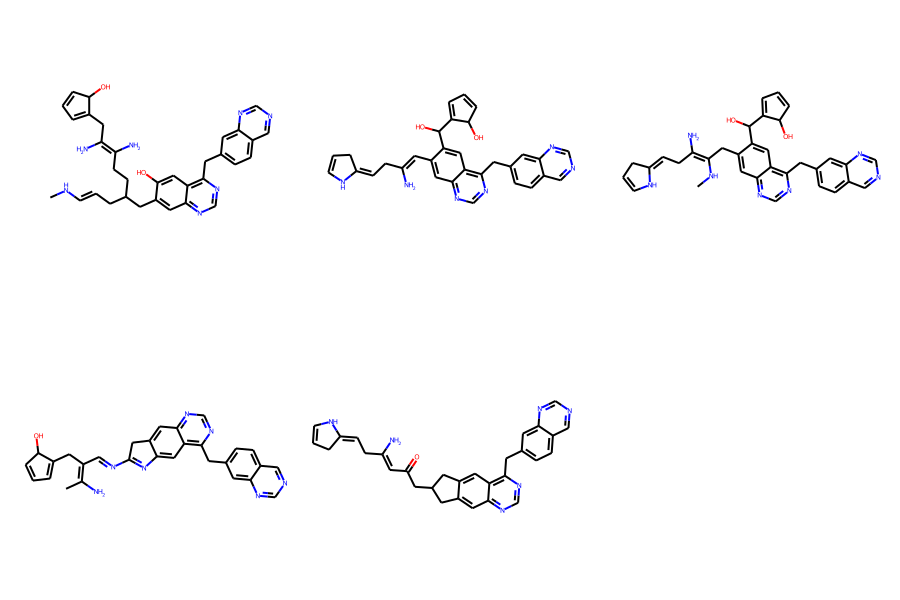

In [ ]:
draw_mols(to_mols(cbc.library[cbc.library.score>10.6].smiles.values))

In [ ]:
mutators = [
    ChangeAtom(),
    AppendAtom(),
    DeleteAtom(),
    ChangeBond(),
    InsertAtom(),
    AddRing()
]

crossovers = [FragmentCrossover()]

def scale_sa(sa):
    return (10-sa)/9

def scale_logp(logp):
    logp = logp/5
    logp = min(max(logp,0),1)
    return logp

def scale_qed(qed):
    return 2*qed

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MolWtFilter(None, 500),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     LogPFilter(None, 5)
                     ],
                    [QEDFilter(None, None, score=PropertyFunctionScore(scale_qed)),
                     SAFilter(None, None, score=PropertyFunctionScore(scale_sa)),
                     LogPFilter(None, None, score=PropertyFunctionScore(scale_logp))], 
                    fail_score=-1., log=False)

In [ ]:
cbc = CombiChem(mutators, crossovers, template=template, 
                prune_percentile=70, max_library_size=500)

In [ ]:
cbc.add_data(list(df.smiles.values[:100]))

In [ ]:
# set_global_pool(32)

In [ ]:
for i in range(5):
    cbc.step()
    print(cbc.library.score.mean(), cbc.library.shape[0])

3.067220218999019 500
3.4245730845372173 500
3.5466574821991363 500
3.5894441371439525 500
3.6129119501563527 500


In [ ]:
for i in range(5):
    cbc.step()
    print(cbc.library.score.mean(), cbc.library.shape[0])

3.6285618723751476 500
3.634952781824757 500
3.6457140714814926 500
3.6469476987038716 500
3.6491692368510082 500


Other mutators

Ring heteroatom shuffle

random addition of predefined group

add ketone/carboxyl

ring aromatize/dearomatize

delete atom in ring and fuse

selfies crossover/mutation